# VALORACIÓN DE OPCIONES USANDO MONTECARLO

## Simulaciones utilizando MonteCarlo

* Las simulaciones de montecarlo son un método usado para valorar opciones financieras.

* El método de simulación de montecarlo es un método estadístico que se basa en la generación de números aleatorios.

* El método consiste en simular el comportamiento de un activo subyacente para calcular los posibles valores en el momento del vencimiento y, a partir de ello, calcular el valor de la opción.

* El valor de una opción se calcula como el valor actual de la esperanza matemática del valor de la opción en el momento del vencimiento

* En la valoración de opciones, las simulaciones de Montecarlo utilizan el resultado de la valoración libre de riesgo

* En el mundo libre de riesgo, la tasa de rendimiento anual esperada y la tasa anual libre de riesgo deben ser iguales para obtener la estimación correcta de la opción y luego se descuenta esta retribución a la tasa libre de riesgo.



### Movimiento Browniano

* Para valorar los derivados como las opciones, lo más importante es encontrar un modelo que represente el precio del valor subyacente, de modo que podamos valorar las opciones en función del precio subyacente.  Normalmente utilizamos el proceso estocástico para modelar el precio.

* El **proceso de Markov** es un caso especial de proceso estocástico.
    * En un proceso de Markov, el valor futuro de una acción $S_{t+1}$, solo depende del valor actual $S_t$, no importa la trayectoria anterior.

    * En general, solemos suponer que el precio de las acciones sigue un proceso estocástico de Markov.

* El **movimiento browniano** es un tipo particular de proceso estocástico de Markov, podemos pensar en él como una familia de variables aleatorias {Wt∣t≥0} indexadas por el tiempo t.

    * El movimiento browniano unidimensional se llama Proceso de Wiener.


    * El **Proceso de Wiener** yiene las siguientes propiedades:

        * $W_{0}=0$

        * Para $t≥0$ y $Δt≥0$, el incremento $W_{t+Δt}-W_{t}$ se distribuye normalmente con media 0 y desviación típica $\sqrt{Δt}$.

        * Para cualquier partición $0≤t_{1}<t_{2}<⋅⋅<t_{n}$, los incrementos $W_{t_{1}}-W_{t_{0}},W_{t_{2}}-W_{t_{1}},⋅⋅⋅,W_{t_{n}}-W_{t_{n-1}}$ son variables aleatorias independientes.

Intuitivamente, **los retornos de un proceso Wiener son independientes y siguen una distribución normal con media 0 y desviación típica $\sqrt{Δt}$**.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf

Vamos a generar, como ejemplo, 5 trayectorias de un proceso Wiener con tiempo total $T=10$ y número de steps $N=1000$.

```python

Defino el proceso Wiener

In [3]:

def wiener_process(T, N):
    """
    T: total time
    N: The total number of steps
    """
    W0 = [0]
    dt = T/float(N)
    # simulate the increments by normal random variable generator
    increments = np.random.normal(0, 1*np.sqrt(dt), N) # media 0 y desviación sqrt(dt)

    #log returns are added
    W = W0 + list(np.cumsum(increments)) 
    return W



Hago las simulaciones y las grafico

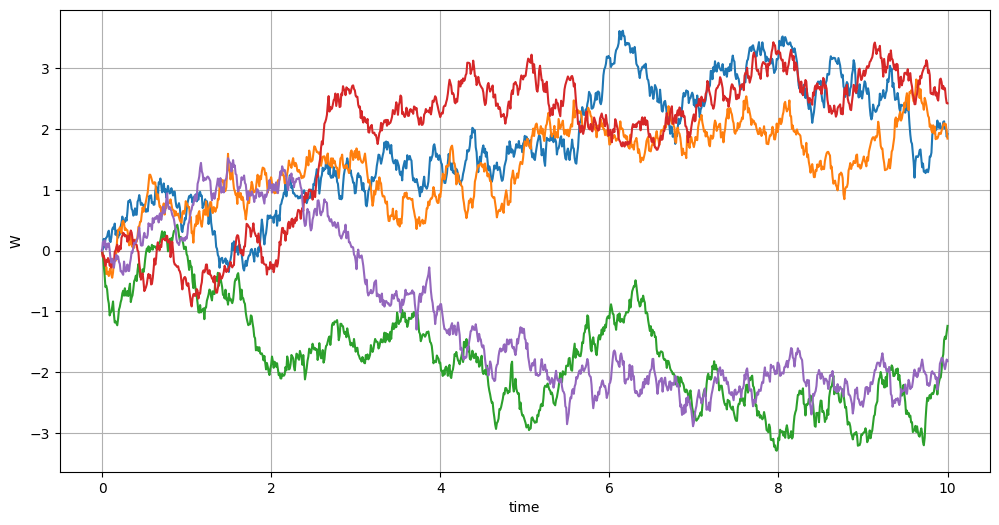

In [4]:
N = 1000
T = 10
dt = T / float(N)
t = np.linspace(0.0, N*dt, N+1)
plt.figure(figsize=(12,6))
for i in range(5):
    W = wiener_process(T, N)
    plt.plot(t, W)
plt.xlabel('time')
plt.ylabel('W')
plt.grid(True)

Existen varios problemas que no permiten usar el proceso Wiener:

* Con la hipótesis de distribución normal de la rentabilidad, existe la posibilidad de que el precio de las acciones sea negativo

* El retorno del proceso de Wiener es independiente de la escala del precio

* El retorno de una acción depende del precio (precios pequeños tienen retornos pequeños y viceversa)

La solución es modelar el incremento proporcional de una acción empleando:

* **Stochastic Differential Equation (SDE)**   $dS_t = \mu S_t dt + \sigma S_t dW_t ...$ (1)

    * $dS_t$ es el cambio en el precio de la acción en un intervalo corto de tiempo de longitud $dt$

    * $\mu$ es la tasa anual de crecimiento del precio de la acción

    * $\sigma$ es la volatilidad anual del precio de la acción


La aproximación discreta de (1) es: $\Delta S = \mu S \Delta t + \sigma S \Delta W$ usando el teorema de Ito llegamos a que el precio logarítmico de una acción sigue una distribución normal

* $\mathbf{ln(S_{t+\Delta t}) = ln(S_t) + (\mu - \frac{1}{2}\sigma^2)\Delta t + \sigma \epsilon \sqrt{\Delta t}}$       ecuación (2)

* Equivalente a:

    * $\mathbf{S_{t+\Delta t} = S_t * exp [(\mu - \frac{1}{2}\sigma^2)\Delta t + \sigma \epsilon \sqrt{\Delta t}]}$

        * $\epsilon$ es una variable aleatoria normal con media 0 y desviación típica 1

        * $\Delta t$ es el tamaño del paso de tiempo

        * $\mu$ es la tasa anual de crecimiento del precio de la acción

        * $\sigma$ es la volatilidad anual del precio de la acción

### Cargamos los datos de yahoo finance

In [5]:
csco = yf.Ticker("CSCO")

# get historical market data
csco_hist = csco.history(period="max")

csco_hist= csco_hist['Close'][csco_hist.index > '2020-01-01'] # get only Close data since 2020-01-01

In [6]:
csco_hist

Date
2020-01-02 00:00:00-05:00    44.417828
2020-01-03 00:00:00-05:00    43.693127
2020-01-06 00:00:00-05:00    43.849079
2020-01-07 00:00:00-05:00    43.564697
2020-01-08 00:00:00-05:00    43.592216
                               ...    
2022-10-10 00:00:00-04:00    39.889999
2022-10-11 00:00:00-04:00    39.580002
2022-10-12 00:00:00-04:00    39.270000
2022-10-13 00:00:00-04:00    40.610001
2022-10-14 00:00:00-04:00    40.200001
Name: Close, Length: 703, dtype: float64

Calculo las rentabilidades y las varianzas anuales

In [7]:
days = 252

mu = (csco_hist.pct_change().mean()) * days
sigma = (csco_hist.pct_change().std())*np.sqrt(days) # annualized volatility

Veo el último valor de cierre

In [9]:
S0 = csco_hist[-1]
S0

40.20000076293945

Defino el número de simulaciones, número de steps, la rentabilidad libre de riesgo y el tiempo total de simulación (T)

In [10]:
T = 3/12 # 3 meses
steps = 100
num_sim = 1000
r = 0.01 # 1% risk free rate

Calculos los datos necesarios para la ecuación (2) teniendo en cuenta que en la simulación risk free: $\mu = r$

$\mathbf{ln(S_{t+\Delta t}) = ln(S_t) + (r - \frac{1}{2}\sigma^2)\Delta t + \sigma \epsilon \sqrt{\Delta t}}$ 

Generamos los retornos siguiendo una distribución normal con media 0 y desviación típica 1 (epsilon)

## Simulación de Montecarlo

* Definimos las siguientes funciones:

    * sim_montecarlo_log: devuelve los log returns de las simulaciones

    * sim_montecarlo: devuelve los precios de las simulaciones

    * valor_montecarlo: devuelve el valor de la opción


In [11]:
def sim_montecarlo_log(S0, T, steps, r, sigma, num_sim):

    lnS0 = np.log(S0) # primer sumando de la ecuación
        
    dt = T/steps
    nudt = (r - 0.5*sigma**2)*dt # segundo sumando de la ecuación

    sigma_sdt = sigma*np.sqrt(dt)
    epsilon = np.random.normal(size=(num_sim, steps))
    increments = sigma_sdt*epsilon # tercer sumando de la ecuación

    delta_lnSt = nudt + increments
    lnSt = lnS0 + np.cumsum(delta_lnSt, axis=1)
    lnSt = np.insert(lnSt, 0, lnS0, axis=1)

    return lnSt

In [12]:
def sim_montecarlo(S0, T, steps, r, sigma, num_sim):

    lnS0 = np.log(S0) # primer sumando de la ecuación
        
    dt = T/steps
    nudt = (r - 0.5*sigma**2)*dt # segundo sumando de la ecuación

    sigma_sdt = sigma*np.sqrt(dt)
    epsilon = np.random.normal(size=(num_sim, steps))
    increments = sigma_sdt*epsilon # tercer sumando de la ecuación

    delta_lnSt = nudt + increments
    lnSt = lnS0 + np.cumsum(delta_lnSt, axis=1)
    lnSt = np.insert(lnSt, 0, lnS0, axis=1)

    return np.exp(lnSt)

In [13]:
def val_opcion_montecarlo(S0, T, steps, r, sigma, num_sim, K, tipo='call'):
    
    St = sim_montecarlo(S0, T, steps, r, sigma, num_sim) # calcula los precios de las acciones en cada paso

    # St[:,-1] El último valor de las simulaciones de precios (precio al vencimiento)
    if tipo == 'call':
        payoff = np.maximum(St[:,-1] - K, 0) # payoff de una opción call. 
    elif tipo == 'put':
        payoff = np.maximum(K - St[:,-1], 0) # payoff de una opción put.
    else:
        raise ValueError('tipo debe ser call o put')

    St_desc = np.exp(-r*T)*payoff # paso rendimientos acumulados a precios

    std_err = np.std(St_desc)/np.sqrt(num_sim) # error estándar de la estimación

    return np.mean(St_desc), std_err

Calculamos el valor de una opción usando simulaciones y lo comparamos con el resultado usando Black-Sholes

In [18]:
val_opcion_montecarlo(50, 1, 100, 0.01,0.3, 10000, 40, tipo='call')

(12.029301234266194, 0.13427302111068398)

In [16]:
# Valoración de una opción call usando Black-Scholes
from options import BsmModel
call_opt = BsmModel('c', 50 ,40,0.01, 1, 0.3)
call_opt.bsm_price()

12.057425084908818

**VALORACIÓN DE OPCIONES CON DATOS REALES**

Leemos los datos del fichero csco_opt.xlsx

In [19]:
csco_opt_calls = pd.read_excel('./data/csco_opt.xlsx')
csco_opt_calls.head()

,lastTradeDate,strike,lastPrice,S0,T,vol
0,2022-08-19,40.0,10.05,48.700001,0.575342,32.958984
1,2022-08-19,42.5,8.35,48.700001,0.575342,33.447266
2,2022-08-19,45.0,6.25,48.700001,0.575342,29.296875
3,2022-08-19,47.5,4.65,48.700001,0.575342,27.709961
4,2022-08-19,50.0,3.45,48.700001,0.575342,27.282715


Grafico los precios y las volatilidades implícitas en función del valor de strike

array([<AxesSubplot: xlabel='strike'>, <AxesSubplot: xlabel='strike'>],
      dtype=object)

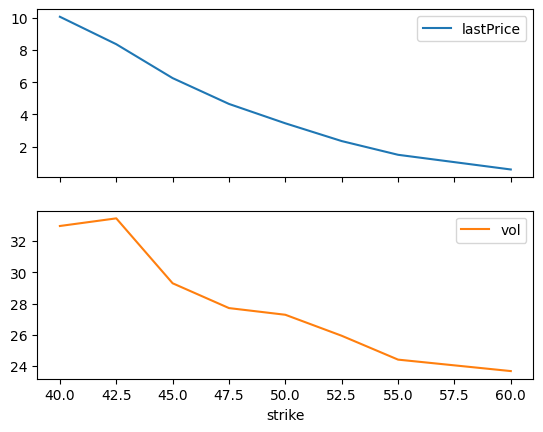

In [20]:
csco_opt_calls[['strike' , 'lastPrice', 'vol']].plot(x='strike', subplots=True)

Doy valores a los variables tomando la opción en la posición pos = 0 para asignar los valores de S0, K, r, div, T, sigma

In [22]:
# Valores reales

pos = 3
S0 = csco_opt_calls.loc[pos, "S0"]
K = csco_opt_calls.loc[pos, "strike"]
T = csco_opt_calls.loc[pos, "T"]
sigma = csco_opt_calls.loc[pos, "vol"]/100
market_price = csco_opt_calls.loc[pos, "lastPrice"]

print(f'Los valores son: Posición {pos}, S0 {S0}, K {K}, T {T}, sigma {sigma}, precio mercado {market_price}')

Los valores son: Posición 3, S0 48.70000076293945, K 47.5, T 0.5753424657534246, sigma 0.277099609375, precio mercado 4.65


In [ ]:
# resto de valores
r = 0.01
div = 0.0 #0.03
steps = 50
num_sim = 1000

Realizo la simulación y la grafico

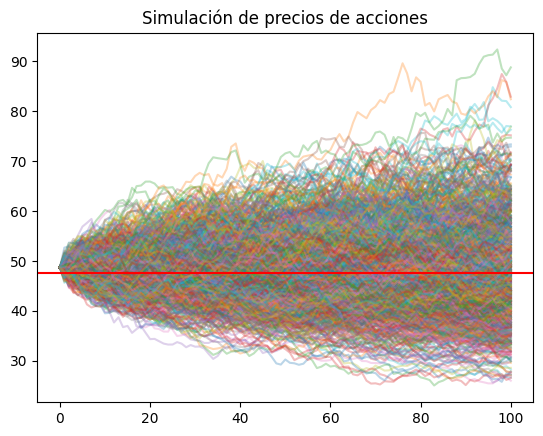

In [29]:
sim_res = sim_montecarlo(S0, T, steps, r, sigma, num_sim)
plt.plot(sim_res.T, alpha=0.3);
plt.axhline(y=K, color='r', linestyle='-')
plt.title('Simulación de precios de acciones')
plt.show()

Calculo el valor de la opción usando simulación de Montecarlo

In [30]:
est_price, std_err = val_opcion_montecarlo(S0, T, steps, r, sigma, num_sim, K, tipo='call')

In [31]:
print(f" Valor de la opción call: {est_price:.2f} con SE: {std_err:.2f}")

 Valor de la opción call: 4.78 con SE: 0.23


Grafico la distribución de los resultaods de la simulación incluyendo el valor de la opción

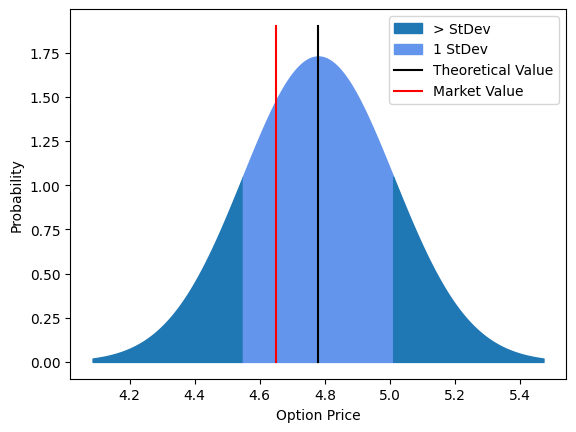

In [32]:

x1 = np.linspace(est_price-3*std_err, est_price-1*std_err)
x2 = np.linspace(est_price-1*std_err, est_price+1*std_err, 100)
x3 = np.linspace(est_price+1*std_err, est_price+3*std_err, 100)

s1 = stats.norm.pdf(x1, est_price, std_err)
s2 = stats.norm.pdf(x2, est_price, std_err)
s3 = stats.norm.pdf(x3, est_price, std_err)

plt.fill_between(x1, s1, color="tab:blue", label = '> StDev')
plt.fill_between(x2, s2, color="cornflowerblue", label = '1 StDev')
plt.fill_between(x3, s3, color="tab:blue")

plt.plot([est_price, est_price], [0, max(s2)*1.1], "k", label = "Theoretical Value")
plt.plot([market_price, market_price], [0, max(s2)*1.1], "r", label = "Market Value")

plt.ylabel('Probability')
plt.xlabel('Option Price')
plt.legend()
plt.show()